In [14]:
import numpy as np
import pandas as pd
import pyBigWig
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import shap
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    f1_score,
    auc
)

In [3]:
def generate_bins(chrom_sizes_path, output_path, bin_size=1000):
    with open(chrom_sizes_path) as f, open(output_path, "w") as out:
        for line in f:
            chrom, size = line.strip().split("\t")
            size = int(size)
            for start in range(0, size, bin_size):
                end = min(start + bin_size, size)
                out.write(f"{chrom}\t{start}\t{end}\n")

if os.path.exists("data/colon_1000bp_bins.bed"):
    print("colon_1000bp_bins.bed already exists. Skipping generation.")
else:
    print("Generating 1000bp bins from hg38.chrom.sizes...")
    generate_bins("data/hg38.chrom.sizes", "data/colon_1000bp_bins.bed")
    print("Generation complete: colon_1000bp_bins.bed")

colon_1000bp_bins.bed already exists. Skipping generation.


In [4]:
bins_df = pd.read_csv("data/colon_1000bp_bins.bed", sep="\t", names=["chrom", "start", "end"])
wanted_chroms = {f"chr{i}" for i in range(1, 23)} | {"chrX"}
bins_df = bins_df[bins_df["chrom"].isin(wanted_chroms)].reset_index(drop=True)
print("Filtered bins:", len(bins_df))

bw_H3K27ac = pyBigWig.open("data/ENCFF277XII_H3K27ac.bigWig")
bw_H3K4me3 = pyBigWig.open("data/ENCFF213WKK_H3K4me3.bigWig")
bw_H3K27me3 = pyBigWig.open("data/ENCFF457PEW_H3K27me3.bigWig")
bw_h3k9me3 = pyBigWig.open("data/ENCFF063OHO_H3K9me3.bigWig")
bw_h3k4me1 = pyBigWig.open("data/ENCFF182EJH_H3K4me1.bigWig")
bw_h3k36me3 = pyBigWig.open("data/ENCFF059WYR_H3K36me3.bigWig")
bw_CTCF = pyBigWig.open("data/ENCFF813QCX_CTCF.bigWig")
bw_RAD21 = pyBigWig.open("data/ENCFF027QAE_RAD21.bigWig")
bw_ATAC = pyBigWig.open("data/ENCFF624HRW_ATAC.bigWig")

h3k27ac_vals = []
h3k4me3_vals = []
h3k27me3_vals = []
h3k9me3_vals = []
h3k4me1_vals = []
h3k36me3_vals = []
CTCF_vals = []
RAD21_vals = []
atac_vals = []

def safe_mean_signal(bw, chrom, start, end):
    try:
        values = np.array(bw.values(chrom, start, end, numpy=True))
        values = values[~np.isnan(values)]
        return np.mean(values) if len(values) > 0 else 0.0
    except:
        return 0.0

for i, row in tqdm(bins_df.iterrows(), total=len(bins_df)):
    chrom = row["chrom"]
    start = int(row["start"])
    end = int(row["end"])

    if start < end:
        try:
            h3k27ac_vals.append(safe_mean_signal(bw_H3K27ac, chrom, start, end))
        except:
            h3k27ac_vals.append(0.0)

        try:
            h3k4me3_vals.append(safe_mean_signal(bw_H3K4me3, chrom, start, end))
        except:
            h3k4me3_vals.append(0.0)

        try:
            h3k27me3_vals.append(safe_mean_signal(bw_H3K27me3, chrom, start, end))
        except:
            h3k27me3_vals.append(0.0)

        try:
            h3k9me3_vals.append(safe_mean_signal(bw_h3k9me3, chrom, start, end))
        except:
            h3k9me3_vals.append(0.0)

        try:
            h3k4me1_vals.append(safe_mean_signal(bw_h3k4me1, chrom, start, end))
        except:
            h3k4me1_vals.append(0.0)

        try:
            h3k36me3_vals.append(safe_mean_signal(bw_h3k36me3, chrom, start, end))
        except:
            h3k36me3_vals.append(0.0)

        try:
            CTCF_vals.append(safe_mean_signal(bw_CTCF, chrom, start, end))
        except:
            CTCF_vals.append(0.0)

        try:
            RAD21_vals.append(safe_mean_signal(bw_RAD21, chrom, start, end))
        except:
            RAD21_vals.append(0.0)

        try:
            atac_vals.append(safe_mean_signal(bw_ATAC, chrom, start, end))
        except:
            atac_vals.append(0.0)
    else:
        h3k27ac_vals.append(0.0)
        h3k4me3_vals.append(0.0)
        h3k27me3_vals.append(0.0)
        h3k9me3_vals.append(0.0)
        h3k4me1_vals.append(0.0)
        h3k36me3_vals.append(0.0)
        CTCF_vals.append(0.0)
        RAD21_vals.append(0.0)
        atac_vals.append(0.0)

bins_df["H3K27ac"] = h3k27ac_vals
bins_df["H3K4me3"] = h3k4me3_vals
bins_df["H3K27me3"] = h3k27me3_vals
bins_df["H3K9me3"] = h3k9me3_vals
bins_df["H3K4me1"] = h3k4me1_vals
bins_df["H3K36me3"] = h3k36me3_vals
bins_df["CTCF"] = CTCF_vals
bins_df["RAD21"] = RAD21_vals
bins_df["ATAC"] = atac_vals

bins_df.to_csv("data/colon_bins.csv", sep="\t", index=False)

Filtered bins: 3031053


100%|██████████| 3031053/3031053 [2:14:16<00:00, 376.20it/s]  


In [5]:
print(bins_df["chrom"].unique())

['chr1' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chrX' 'chr8' 'chr9'
 'chr11' 'chr10' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17' 'chr18'
 'chr20' 'chr19' 'chr22' 'chr21']


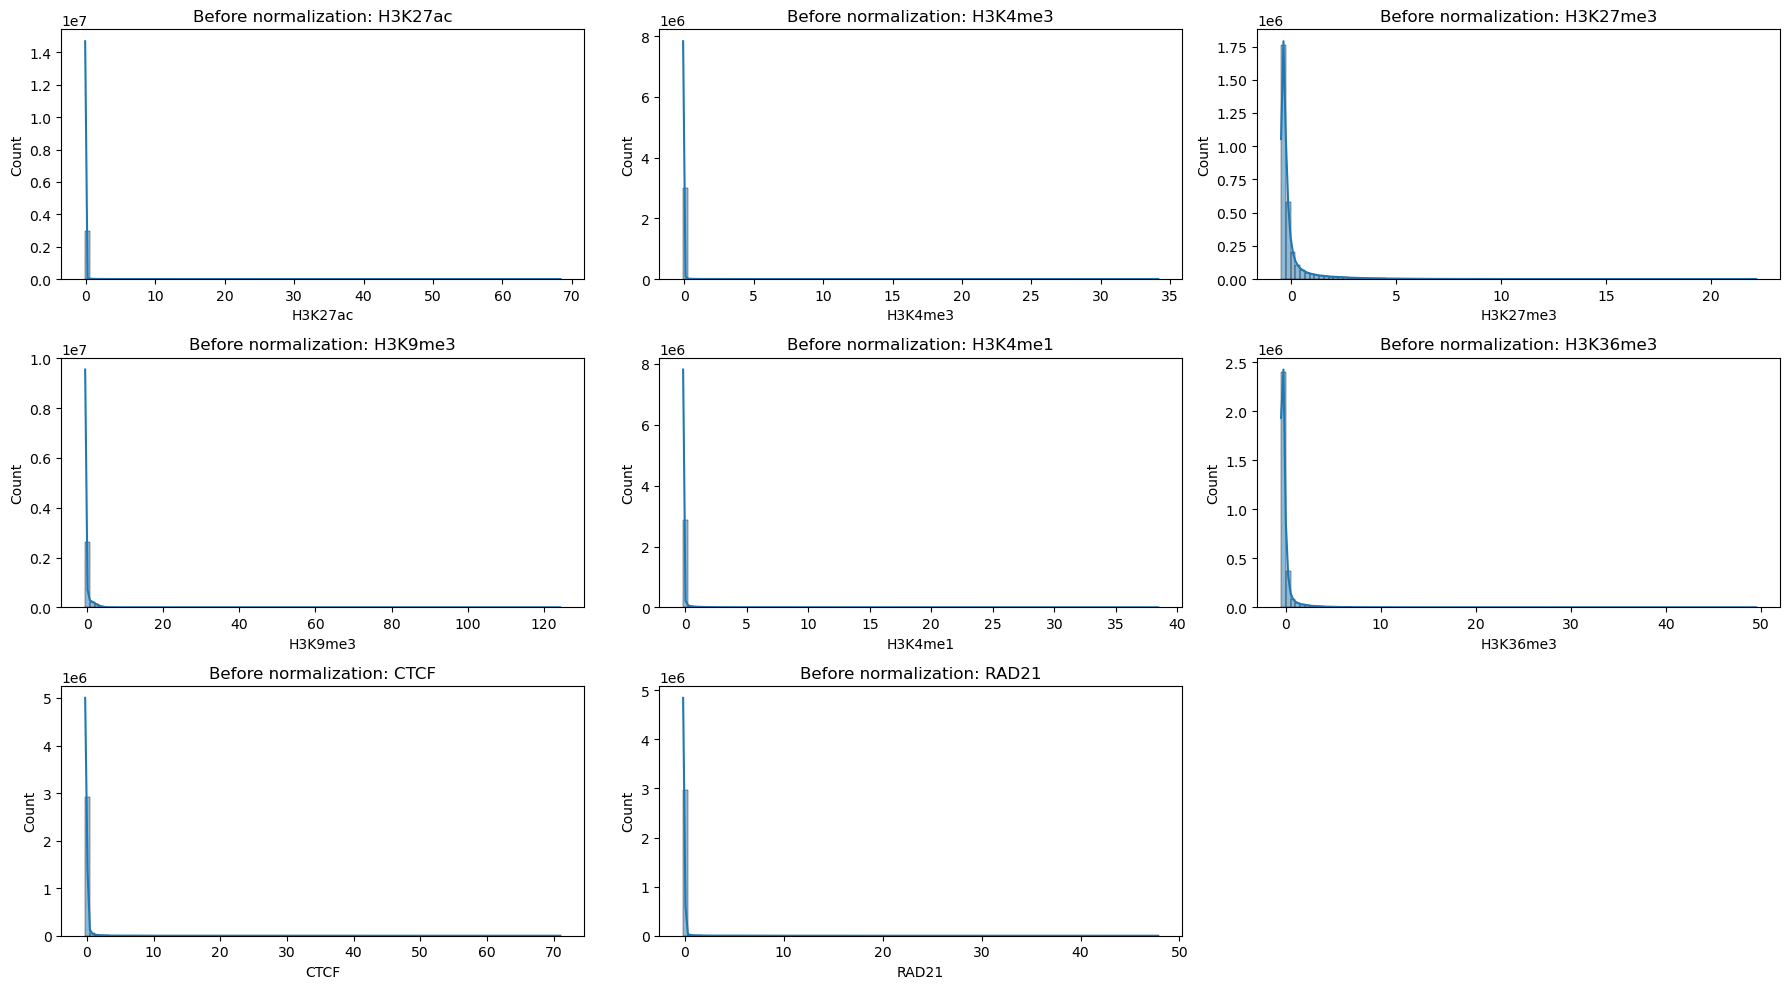

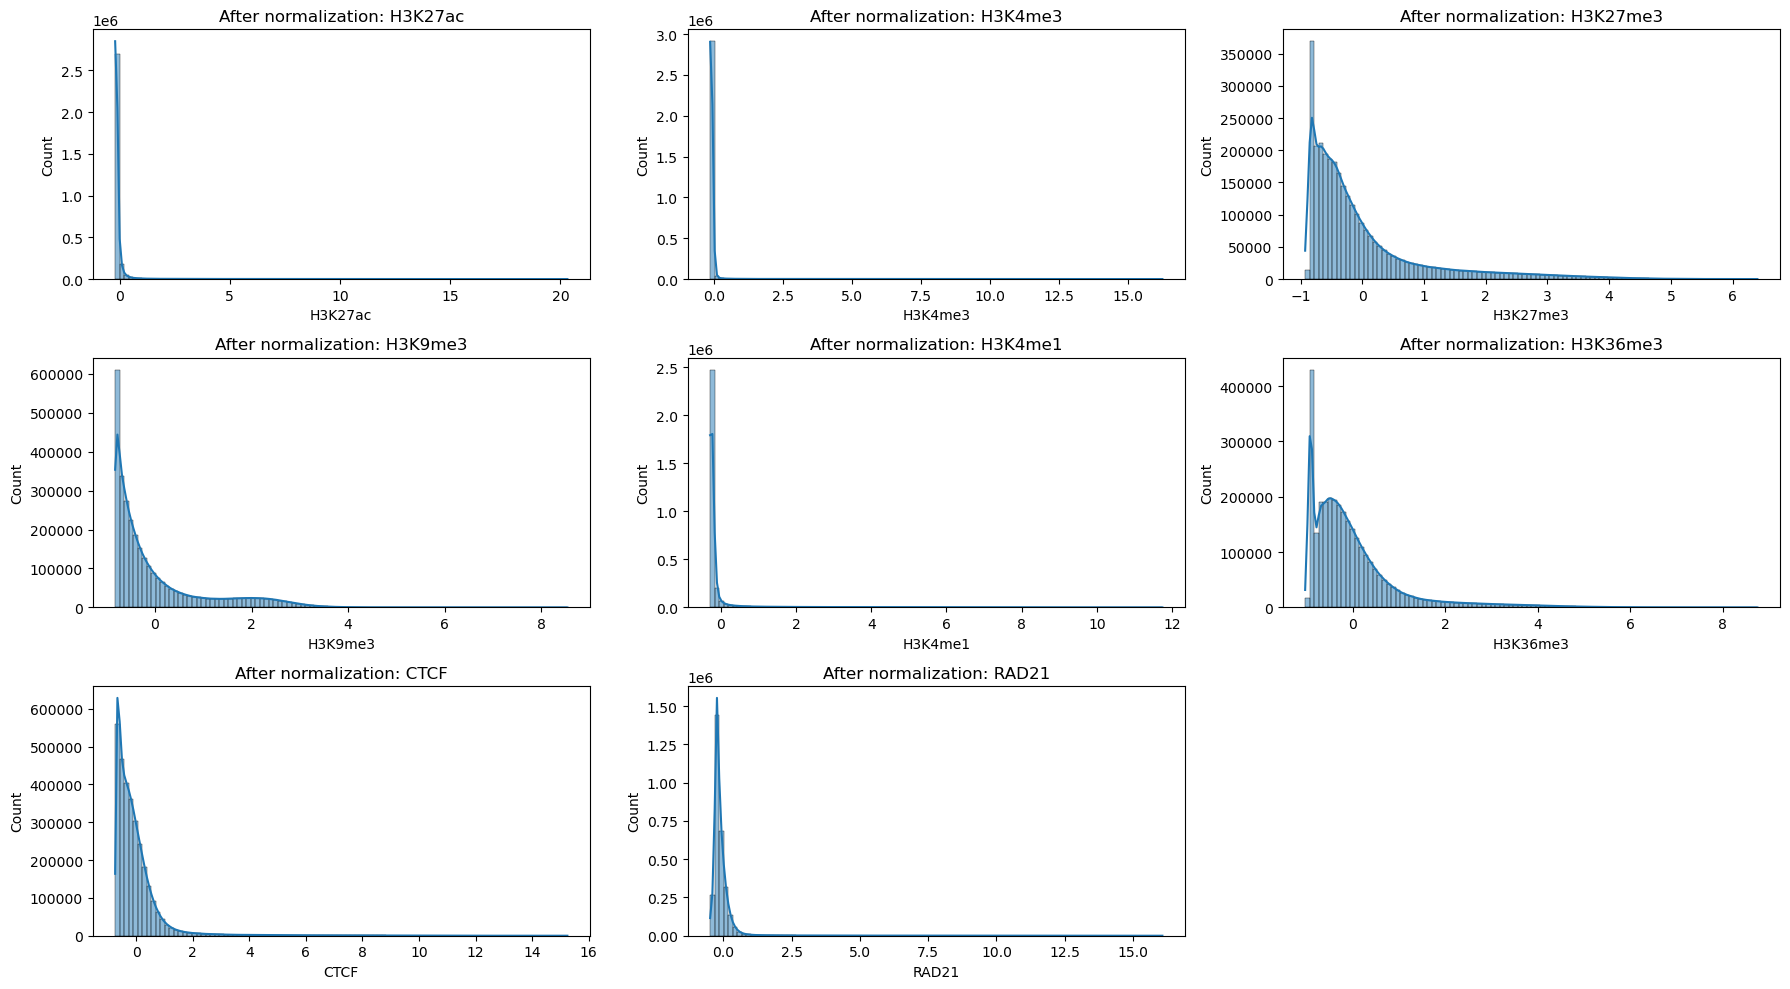

In [7]:
signal_features = [
    "H3K27ac", "H3K4me3", "H3K27me3", "H3K9me3",
    "H3K4me1", "H3K36me3", "CTCF", "RAD21"
]

plt.figure(figsize=(18, 10))
for i, feature in enumerate(signal_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(bins_df[feature], bins=100, kde=True)
    plt.title(f"Before normalization: {feature}")
plt.tight_layout()
plt.show()

scaler = StandardScaler()
bins_df[signal_features] = bins_df[signal_features].replace(0, 1e-6)
bins_df[signal_features] = np.log1p(bins_df[signal_features])
bins_df[signal_features] = scaler.fit_transform(bins_df[signal_features])

plt.figure(figsize=(18, 10))
for i, feature in enumerate(signal_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(bins_df[feature], bins=100, kde=True)
    plt.title(f"After normalization: {feature}")
plt.tight_layout()
plt.show()

threshold = np.percentile(bins_df["ATAC"], 90)
bins_df["label"] = (bins_df["ATAC"] >= threshold).astype(int)

bins_df.to_csv("data/labeled_colon_bins.csv", sep="\t", index=False)

In [10]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

def train_and_save():
    bins_df = pd.read_csv("data/labeled_colon_bins.csv", sep="\t")
    bins_df = bins_df.drop(columns=['ATAC'])

    non_feature_cols = ["chrom", "start", "end", "label"]
    feature_names = [col for col in bins_df.columns if col not in non_feature_cols]

    held_out_chrom = "chr1"
    train_df = bins_df[bins_df["chrom"] != held_out_chrom].copy()
    test_df = bins_df[bins_df["chrom"] == held_out_chrom].copy()

    X_train = train_df[feature_names].values.astype(np.float32)
    y_train = train_df["label"].astype(np.float32).values

    X_test = test_df[feature_names].values.astype(np.float32)
    y_test = test_df["label"].astype(np.float32).values

    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).unsqueeze(1))
    test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test).unsqueeze(1))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    num_neg = (y_train == 0).sum()
    num_pos = (y_train == 1).sum()
    pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32)

    model = SimpleNN()
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 30
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            preds = torch.sigmoid(logits) >= 0.5  # Temporary for tracking accuracy
            correct += (preds == yb.bool()).sum().item()
            total += yb.size(0)

        train_acc = correct / total

        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                logits = model(xb)
                preds = torch.sigmoid(logits) >= 0.5
                correct_test += (preds == yb.bool()).sum().item()
                total_test += yb.size(0)

        test_acc = correct_test / total_test

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / total:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")

    os.makedirs("outputs", exist_ok=True)
    torch.save(model.state_dict(), "outputs/simple_nn_model.pth")
    np.save("outputs/X_test.npy", X_test)
    np.save("outputs/y_test.npy", y_test)

    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            logits = model(xb)
            probs = torch.sigmoid(logits)
            all_probs.extend(probs.squeeze().numpy())
            all_labels.extend(yb.squeeze().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    j_scores = tpr - fpr
    best_thresh = thresholds[np.argmax(j_scores)]
    print(f"\nBest dynamic threshold (Youden’s J): {best_thresh:.4f}")

    best_preds = (all_probs >= best_thresh).astype(int)

    np.save("outputs/probs.npy", all_probs)
    np.save("outputs/preds.npy", best_preds)
    np.save("outputs/labels.npy", all_labels)

    print("\nTraining complete. Model and predictions saved.")

if __name__ == "__main__":
    train_and_save()

Epoch 1/30, Loss: 0.6975
Train Accuracy: 0.8267
Test Accuracy: 0.7743
Epoch 2/30, Loss: 0.6844
Train Accuracy: 0.8220
Test Accuracy: 0.7714
Epoch 3/30, Loss: 0.6812
Train Accuracy: 0.8264
Test Accuracy: 0.7748
Epoch 4/30, Loss: 0.6791
Train Accuracy: 0.8314
Test Accuracy: 0.7633
Epoch 5/30, Loss: 0.6780
Train Accuracy: 0.8323
Test Accuracy: 0.7986
Epoch 6/30, Loss: 0.6773
Train Accuracy: 0.8331
Test Accuracy: 0.7843
Epoch 7/30, Loss: 0.6769
Train Accuracy: 0.8334
Test Accuracy: 0.7849
Epoch 8/30, Loss: 0.6764
Train Accuracy: 0.8334
Test Accuracy: 0.7762
Epoch 9/30, Loss: 0.6761
Train Accuracy: 0.8336
Test Accuracy: 0.7920
Epoch 10/30, Loss: 0.6759
Train Accuracy: 0.8338
Test Accuracy: 0.8044
Epoch 11/30, Loss: 0.6755
Train Accuracy: 0.8339
Test Accuracy: 0.7982
Epoch 12/30, Loss: 0.6753
Train Accuracy: 0.8344
Test Accuracy: 0.7887
Epoch 13/30, Loss: 0.6751
Train Accuracy: 0.8339
Test Accuracy: 0.7833
Epoch 14/30, Loss: 0.6749
Train Accuracy: 0.8340
Test Accuracy: 0.7742
Epoch 15/30, Lo

Confusion Matrix:
 [[188505  31566]
 [  6639  22247]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9660    0.8566    0.9080    220071
         1.0     0.4134    0.7702    0.5380     28886

    accuracy                         0.8465    248957
   macro avg     0.6897    0.8134    0.7230    248957
weighted avg     0.9019    0.8465    0.8651    248957


ROC AUC: 0.8997


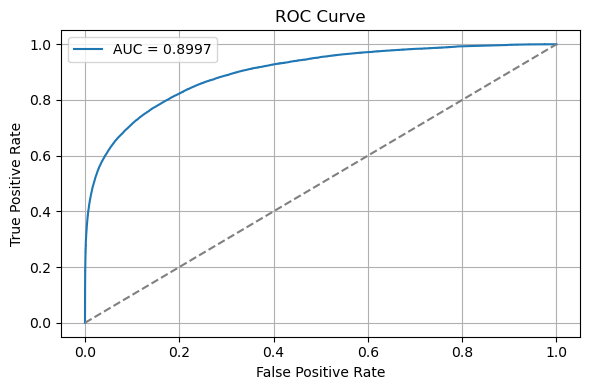

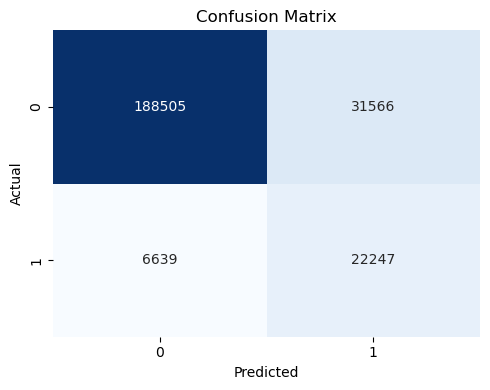

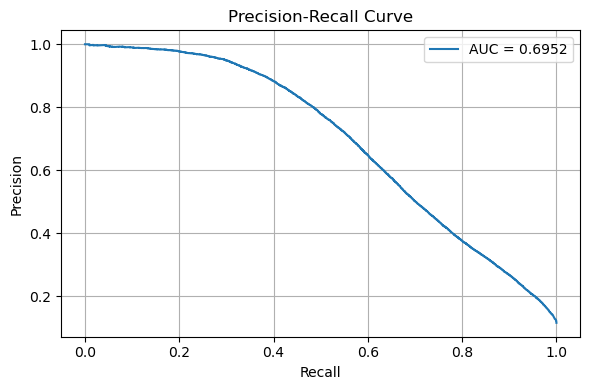

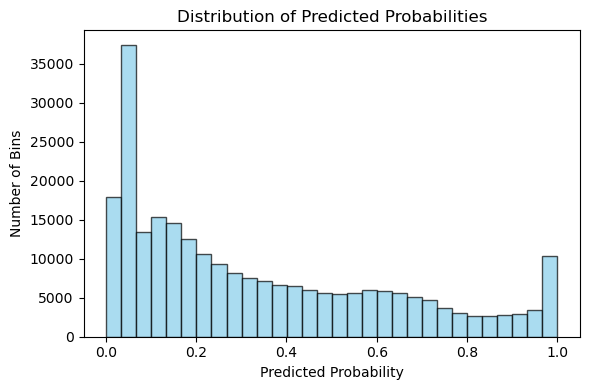

In [12]:
all_probs = np.load("outputs/probs.npy")
all_preds = np.load("outputs/preds.npy")
all_labels = np.load("outputs/labels.npy")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# ROC AUC and Curve
roc_auc = roc_auc_score(all_labels, all_probs)
print(f"\nROC AUC: {roc_auc:.4f}")
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("outputs/roc_curve.png", dpi=300)
plt.close()

# Confusion Matrix Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
plt.savefig("outputs/confusion_matrix.png", dpi=300)
plt.close()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("outputs/precision_recall_curve.png", dpi=300)
plt.close()

# Probability Distribution
plt.figure(figsize=(6, 4))
plt.hist(all_probs, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Bins")
plt.title("Distribution of Predicted Probabilities")
plt.tight_layout()
plt.show()
plt.savefig("outputs/probability_distribution.png", dpi=300)
plt.close()

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/rz/1k_9jccn62l2q3hxnbq_q6nw0000gp/T/ipykernel_73151/212632704.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_display, feature_names=feature_names, show=False)


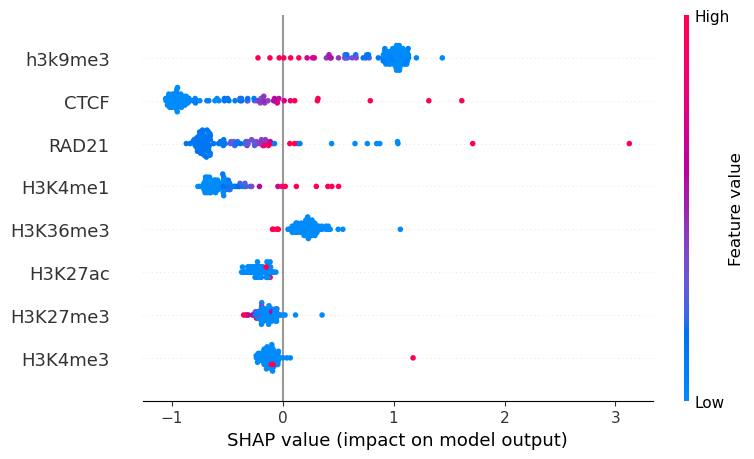

In [20]:
X_test = np.load("outputs/X_test.npy")
y_test = np.load("outputs/y_test.npy")

model = SimpleNN()
model.load_state_dict(torch.load("outputs/simple_nn_model.pth"))
model.eval()

def model_forward(x_np):
    x_tensor = torch.tensor(x_np, dtype=torch.float32)
    with torch.no_grad():
        logits = model(x_tensor)
    return logits.numpy().flatten()

background = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]
X_display = X_test[:100]

explainer = shap.KernelExplainer(model_forward, background)
shap_values = explainer.shap_values(X_display, nsamples=100)

if isinstance(shap_values, list):
    shap_values = shap_values[0]

feature_names = ["H3K27ac", "H3K4me3", "H3K27me3", "h3k9me3", "H3K4me1", "H3K36me3", "CTCF", "RAD21"]

plt.figure()
shap.summary_plot(shap_values, X_display, feature_names=feature_names, show=False)
plt.tight_layout()
plt.show()
plt.close()


/var/folders/rz/1k_9jccn62l2q3hxnbq_q6nw0000gp/T/ipykernel_73151/1248950472.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_display, feature_names=feature_names, plot_type="bar", show=False)


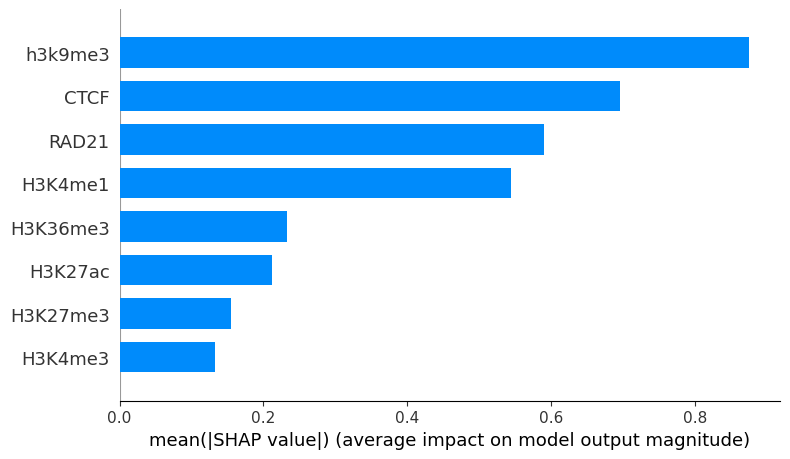

In [21]:
shap.summary_plot(shap_values, X_display, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
plt.show()
plt.close()

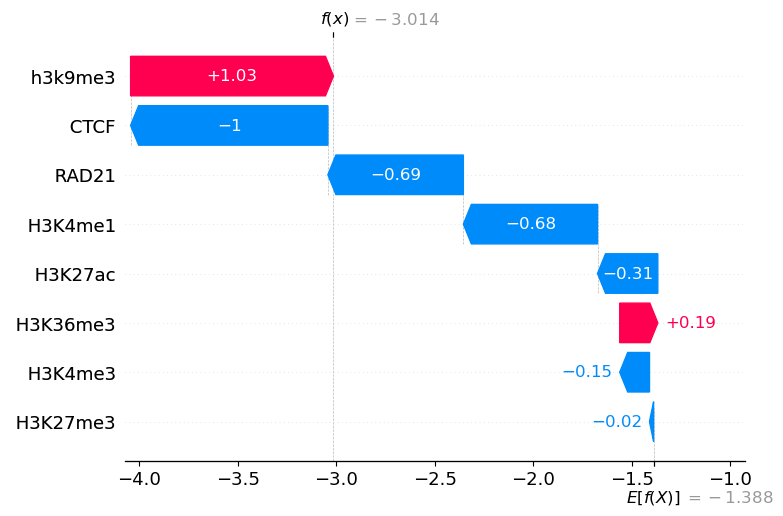

<Figure size 640x480 with 0 Axes>

In [24]:
sample_index = 0

shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value,
    shap_values=shap_values[sample_index],
    features=X_display[sample_index],
    feature_names=feature_names
)

plt.tight_layout()
plt.show()
plt.close()